# ε-greedy法

---

$\epsilon$-greedy法とは強化学習の行動選択時に用いられるアルゴリズムで，$\epsilon$[0,1]の確率で探索を行い，1-$\epsilon$の確率で状態行動価値関数の1番高い行動を選択してくれるというアルゴリズムです．

---
まず, $\epsilon$-greedy法のアルゴリズムを見ていきます．


In [2]:
# Q:状態価値関数,epsilon:[0,1]の任意の値,A:行動数とします 
import numpy as np
import random
A = 3
def epsilon_greedy(Q:np.ndarray,epsilon:float):
    if random.random()< epsilon:
        return np.random.choice(A)
    else:
        return Q.argmax(axis=-1)
    

---

今回はこの[論文](https://arxiv.org/pdf/1807.03765.pdf)のappendix Aに書かれている内容で$\epsilon$-greedy法が強化学習においてあまり良くないことを説明していきます．

まず，次のようなMDPを考えます．

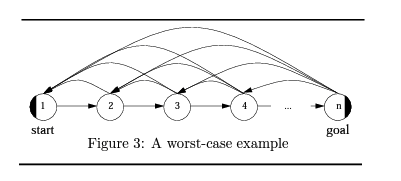

このMDPは状態が[1,n]まであり，各状態において最適な行動$a^*$が一つあり，それ以外の行動を選ぶとuniformな確率でそれ以前の状態に戻されるというMDPです．

しかしながら，[1,n/2]の状態までで$a^*$を選択しても報酬は0のままで[n/2 + 1,n]から$a^*$を選択すると，報酬が1生成される仕組みです．

初期の状態行動価値関数$Q(s_1,a_1) = 0$で初期化します．

このようなMDPを考えると,[1,n/2]まで進めても状態行動価値関数は0のままで学習が進まない確率は最大で$A^{-H/2}$で起きてしまい，iterationの数を$\Omega({A^{H/2}})$以上試行しないと，各iterationで$H/2$のリグレットが発生してしまいます．

---

早速コードを書いていきます．

今回はnを20に設定し,遷移確率Pは決定的とします．

In [13]:
import jax
import jax.numpy
from typing import NamedTuple
import matplotlib.pyplot as plt

S = 20
A = 2 #S-1の時に行動の選択肢がS-1個あるため
S_array = np.arange(S)
A_array = np.arange(A)
gamma = 1.0

#最適な行動はA=0の時にします．

rew = np.zeros((S,A))
rew[10:,0] = 1.0

P = np.zeros((S,A,S))
for s in range(S):
    if s == 0:
        P[s,0,s+1] = 1.0
        P[s,1,s] = 1.0
        continue

    P[s,0,min(s+1,S-1)] = 1.0
    P[s,1,np.arange(0,s)] = 1.0/s

class MDP(NamedTuple):
    S_array : np.array
    A_array : np.array
    gamma : float
    P:np.array
    rew : np.array
    horizon : int
    

    @property
    def S(self) -> int:
        return len(self.S_array)

    @property
    def A(self) -> int:
        return len(self.A_array)

horizon = 20
mdp = MDP(S_array,A_array,gamma,P,rew,horizon)

print(mdp.rew.shape)
np.testing.assert_almost_equal(P.sum(axis=-1),1)


(20, 2)


In [18]:
import jax.numpy as jnp

@jax.jit
def get_greedy(mdp:MDP,q:np.ndarray):

    pi_max = jnp.zeros((mdp.S,mdp.A))
    pi_max = pi_max.at[np.arange(S),q.argmax(axis=1)].set(1)

    return pi_max

def eps_greedy(mdp:MDP,q:np.ndarray,eps:float):
    if random.random() < eps:
        action_index = random.randint(0,mdp.A-1)
        pi = jnp.zeros((mdp.S,mdp.A))
        return pi.at[np.arange(S),action_index].set(1)
    else:
        return get_greedy(mdp,q)
    
    


In [19]:
@jax.jit
def Bellman_expected_operator(mdp:MDP, q:jnp.array, pi:np.array):
    S,A = mdp.S,mdp.A
    assert q.shape == (S,A)
    assert pi.shape == (S,A)
    # 行動のサメーション取ると行動価値関数から価値関数になる．
    v = (pi * q).sum(axis=1)
    P_v = mdp.P @ v

    return rew + mdp.gamma * P_v

100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


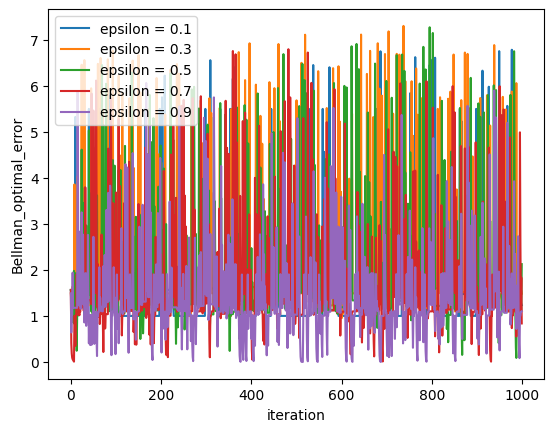

In [23]:
import matplotlib.pyplot as plt
key = jax.random.PRNGKey(0)

S, A = mdp.S, mdp.A

epsilon = [0.1, 0.3, 0.5, 0.7, 0.9]

from tqdm import tqdm
for eps in tqdm(epsilon):
    q_before = jax.random.uniform(key,shape=[S, A])  #Q関数の初期値を一様分布から作成
    errors = []


    # ベルマン最適作用素を繰り返し適用して、収束するか確認してみます
    for i in range(1000):
        pi = eps_greedy(mdp,q_before,eps)
        q_after = Bellman_expected_operator(mdp, q_before,pi)
        errors.append(np.abs(q_after - q_before).max())
        q_before = q_after

    plt.plot(errors, label= f'epsilon = {eps}')
plt.xlabel('iteration')
plt.ylabel('Bellman_optimal_error')
plt.legend()

収束しませんね．